In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats

In [3]:
import datetime
from datetime import datetime,timedelta
from itertools import chain

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# Crate an engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Get column names for measurement table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [130]:
# Get column names for station table
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [131]:
# Retrive the last date point
last_date = (engine.execute('select date from measurement order by date desc').first())[0]
last_date

'2017-08-23'

In [132]:
# Calculate the date 1 year ago from the last data point in the database
year, month, day = map(int, last_date.split("-"))
year_ago = datetime(year, month, day) - timedelta(days=365)
print(year_ago.strftime("%Y-%m-%d"))

2016-08-23


In [133]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_year_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()
last_year_prcp

[('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06', 0.0),
 ('2016-10-07'

In [135]:
# Perform a query to retrieve the data and precipitation scores
date = [row[0] for row in last_year_prcp]
precipitation =  [row[1] for row in last_year_prcp]

# Save the query results as a Pandas DataFrame and set the index to the date column
climate_df = pd.DataFrame({'date' : date,
                           'precipitation' : precipitation}).set_index('date')

# Sort the dataframe by date
climate_df = climate_df.sort_values('date')
climate_df.head()

,precipitation
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


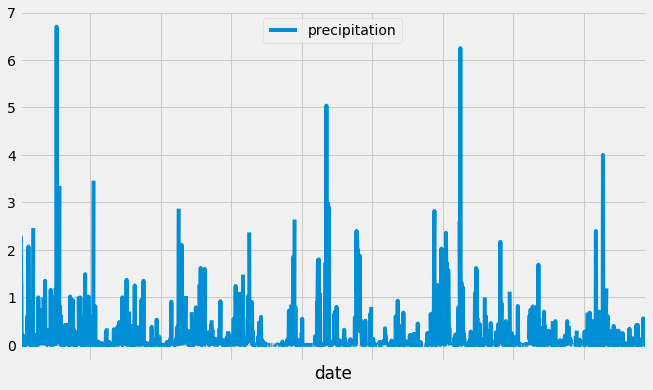

In [139]:
# Use Pandas Plotting with Matplotlib to plot the data
climate_df.plot(figsize = (10,6))
plt.xlabel("date")
plt.tick_params(
    axis='x',          
    which='both',      # both major and minor ticks are affected
    labelbottom=False) # remove x ticks label
plt.legend(loc = 'upper center')
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
climate_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.name)).all()

[(9)]

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
engine.execute('select station, count(station) as count from measurement group by station order by count desc').fetchall()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
engine.execute('select min(tobs), max(tobs), avg(tobs) from measurement where station = "USC00519281"').fetchall()

[(54.0, 85.0, 71.66378066378067)]

In [22]:
# Choose the station with the highest number of temperature observations.
engine.execute('select station, tobs from measurement where station = "USC00519281"').fetchall() 

[('USC00519281', 70.0),
 ('USC00519281', 62.0),
 ('USC00519281', 74.0),
 ('USC00519281', 75.0),
 ('USC00519281', 74.0),
 ('USC00519281', 76.0),
 ('USC00519281', 69.0),
 ('USC00519281', 66.0),
 ('USC00519281', 70.0),
 ('USC00519281', 75.0),
 ('USC00519281', 64.0),
 ('USC00519281', 60.0),
 ('USC00519281', 61.0),
 ('USC00519281', 68.0),
 ('USC00519281', 64.0),
 ('USC00519281', 66.0),
 ('USC00519281', 67.0),
 ('USC00519281', 70.0),
 ('USC00519281', 67.0),
 ('USC00519281', 67.0),
 ('USC00519281', 69.0),
 ('USC00519281', 60.0),
 ('USC00519281', 75.0),
 ('USC00519281', 75.0),
 ('USC00519281', 65.0),
 ('USC00519281', 75.0),
 ('USC00519281', 69.0),
 ('USC00519281', 67.0),
 ('USC00519281', 66.0),
 ('USC00519281', 69.0),
 ('USC00519281', 72.0),
 ('USC00519281', 67.0),
 ('USC00519281', 65.0),
 ('USC00519281', 64.0),
 ('USC00519281', 67.0),
 ('USC00519281', 67.0),
 ('USC00519281', 68.0),
 ('USC00519281', 69.0),
 ('USC00519281', 66.0),
 ('USC00519281', 69.0),
 ('USC00519281', 61.0),
 ('USC00519281',

In [23]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data = engine.execute('select tobs from Measurement where date >= "2016-08-23" and station = "USC00519281"').fetchall()
data = [row[0] for row in data]
hist_data = pd.DataFrame({'tobs': data})

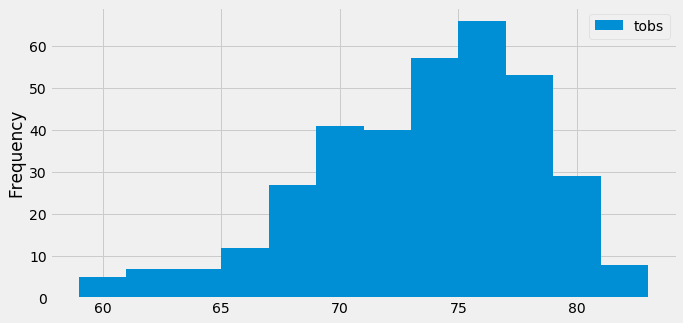

In [24]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
hist = hist_data.hist(bins = 12, figsize = (10,5))
plt.ylabel("Frequency")
plt.title("")
plt.legend(["tobs"])

# Optional Challenge Assignment

## Temperature Analysis I

In [25]:
# Identify the average temperature in June at all stations across all available years in the dataset.
june = '06'
june_temperature = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == june).all()

# Do the same for December temperature.
dec = '12'
dec_temperature = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == dec).all()

# Use the t-test to determine whether the difference in the means
stats.ttest_ind(june_temperature, dec_temperature, equal_var = False)

Ttest_indResult(statistic=array([31.35503692]), pvalue=array([4.19352984e-187]))

## Temperature Analysis II

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# trip date is 2018-01-16, 2018-01-22

my_trip = (calc_temps('2017-01-16', '2017-01-22'))
print(my_trip)

[(66.0, 71.86363636363636, 80.0)]


In [28]:
# Create a dataframe using the result
my_trip_df = pd.DataFrame(my_trip, columns = ['min', 'avg', 'max'])
my_trip_df

,min,avg,max
0,66.0,71.863636,80.0


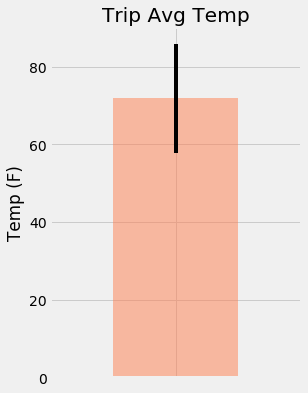

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title, average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = [my_trip_df['max']-my_trip_df['min']]
my_trip_df.plot(kind = 'bar', y='avg', yerr=error, title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(4,6), legend = '')
plt.ylabel("Temp (F)")
plt.tick_params(
    axis='x',          
    which='both', 
    labelbottom=False) 

## Daily Rainfall Average

In [30]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
engine.execute('select measurement.station, name, latitude, longitude, elevation, sum(prcp) as total_rainfall \
                from measurement\
                join station on measurement.station = station.station \
                where date between "2017-01-16" and "2017-01-22" \
                group by measurement.station order by total_rainfall desc').fetchall()

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.87),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.16),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.15),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.14),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.05),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.02),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]

In [70]:
session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation,func.sum(Measurement.prcp)).\
                filter(Measurement.station == Station.station).filter(Measurement.date >= '2017-01-16').filter(Measurement.date <= '2017-01-22').\
                                                                                                            group_by(Measurement.station).all()

[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.05),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.02),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.87),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.14),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.16),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.15)]

In [31]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [32]:
# Set the start and end date of the trip
start_date = '2018-01-16'
end_date = '2018-01-22'

# Use the start and end date to create a range of dates
my_dates  = pd.date_range(start_date, end_date).strftime('%Y-%m-%d')
my_dates

Index(['2018-01-16', '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20',
       '2018-01-21', '2018-01-22'],
      dtype='object')

In [33]:
# Stip off the year and save a list of %m-%d strings
months_dates = pd.date_range(start_date, end_date).strftime('%m-%d')
months_dates

Index(['01-16', '01-17', '01-18', '01-19', '01-20', '01-21', '01-22'], dtype='object')

In [34]:
normals = []
# Loop through the list of %m-%d strings and calculate the normals for each date
for date in months_dates:
    normal = daily_normals(date)
    # push each tuple of calculations into a list called `normals`
    normals.append(normal)
normals

[[(54.0, 68.62962962962963, 80.0)],
 [(61.0, 69.07407407407408, 76.0)],
 [(57.0, 68.63157894736842, 77.0)],
 [(60.0, 68.26315789473684, 78.0)],
 [(61.0, 68.86666666666666, 78.0)],
 [(61.0, 70.14545454545454, 76.0)],
 [(60.0, 69.26415094339623, 76.0)]]

In [35]:
# Load the previous query results into a Pandas DataFrams
new_list = [x for x in chain.from_iterable(normals)]
my_trip_df = pd.DataFrame(new_list, columns = ['tmin','tavg','tmax'])

# Add the `trip_dates` range as the `date` index
my_trip_df['date'] = my_dates
my_trip_df = my_trip_df.set_index('date')
my_trip_df

,tmin,tavg,tmax
date,,,
2018-01-16,54.0,68.629630,80.0
2018-01-17,61.0,69.074074,76.0
2018-01-18,57.0,68.631579,77.0
2018-01-19,60.0,68.263158,78.0
2018-01-20,61.0,68.866667,78.0
2018-01-21,61.0,70.145455,76.0
2018-01-22,60.0,69.264151,76.0


(array([0., 1., 2., 3., 4., 5., 6.]), <a list of 7 Text xticklabel objects>)

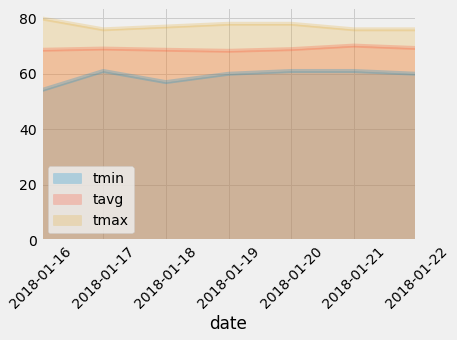

In [36]:
# Plot the daily normals as an area plot with `stacked=False`
my_trip_df.plot(kind = 'area', stacked = False, alpha = 0.25)
plt.xticks(rotation = 45)